# Industrial economy

## Aim of work : 
* Compare classic Cournot oligopoly equilibrium with results obtained with a simple iterative process where players evolve their optimal strategies
* Different market concentration [monopoly, duopoly, triopoly]
* One sided auction : 
    1. Each indiv. firm selects its outpout
    2. Simultaneous offer of quantities to the market
    3. Compute a uniform price for all of these quantities
    4. Each indiv. compute its profits
    5. Thanks to profit each indiv. submits new quanity
> Repeat

### Market rules
$$P(Q) = 600 - Q $$
$$Q = \sum q_i $$
* All players are homogeneous hence : cost = 0

### Production design
* Random pick between 
*With n : number of firms*
$$Q \in ]0;5*IntegePart(120/n]$$
* Produce between 0 and a max capacity 
* All firms have identical production
* Set of individual bid is discrete : 
    * Can only take values such as 5-units increments : 
    * We have a bid index link to a quantity produced
    * 5,10 ... K-5, K with K=5
    * Set of S 
    * Uniform probability
    
![Auction_table](table_auction.png)

### Load packages

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data structure

### We are going to have : 
* With : p = periods 
* With : n = number of firms
* With : s = number of bids possibilities - depending of E(120/n)

#### A)  Bid matrix :
* A matrix : p rows & n columns (p,n)
    * bid(p,n) = Bid of firm n at period p

#### B)  Profit matrix:
* A matrix : p rows & n columns (p,n)
    * profit(p,n) = Profit of firm n at period p


#### C)  Propensions matrix:
* A matrix : s rows & n columns (s,n)
    * prop(s,n) = Propensions of bid s for firm n


In [6]:
n= 10 # number of firms
p = 1000 # number of periods
s = int((120/n)//1)
bid_mat = np.zeros((n,p)) # Bid matrix
profit_mat = np.zeros((n,p)) # Profit matrix
prop_mat = np.zeros((s,p)) # Propensions matrix

## Build framework

![consignes](consignes.png)


In [203]:
def cournot_framework(n_firms, p_periods,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    """Cournot framework
    Args :
        n_firms (int): Number of firms 
        p_periods (int): Number of simulation periods
        initial_propension (float) : initial_propension for each value
        mu (float) : extinction in finite time
        gamma (float) : forget rate 
        delta (flaot) : propension increaser
        total_demand (int): total demand of market
    Returns : 
        bid_mat (np.matrix): Matrix of bid for each firm at each period
        profit_mat (np.matrix): Matrix of profit for each firm at each period
        prop_mat (np.matrix) : Propension matrix for each bid for each firm for each period
        price_vec (np.array) : Market price for each period"""
    s_discrete = int((120/n_firms)//1) #Integer part of 120/n
    bid_mat = np.zeros((p_periods,n_firms)) # Bid matrix
    profit_mat = np.zeros((p_periods,n_firms)) # Profit matrix
    prop_mat = np.ones((s_discrete,n_firms,p_periods))*initial_propension # Propensions matrix
    bid_possibilities = np.arange(1,s_discrete+1)*5
    price_vec = np.zeros(p_periods)
    for period in range(p_periods):
        prob_mat = prop_mat[:,:,period]/sum(prop_mat[:,:,period]) #probability matrix
        for firm in range(n_firms):
            ### Across all firms
            bid_pick = np.random.choice(bid_possibilities,p=prob_mat[:,firm])
            bid_mat[period,firm] = bid_pick
        # Once bid are made we can compute price
        market_price = total_demand-sum(bid_mat[period,:])
        price_vec[period] = market_price
        profit_mat[period,:] = market_price*bid_mat[period,:]
        # Need to recompute propensions for next iterations
        for firm in range(n_firms):
            for s_bid in range(s_discrete):
                # Part 1 of reinforcement :
                lambda_ = bid_mat[period,firm]
                # Current propension for this period
                propension = prop_mat[s_bid,firm,period]
                profit = profit_mat[period,firm]
                new_propension = propensions_reinforcement_part1(s_bid,propension,profit,lambda_,delta,gamma)
                # Set propension for next period
                if period + 1 < p_periods:
                    ## Do not outbound
                    prop_mat[s_bid,firm,period+1] = new_propension
            # Second part : adjust regarding mu
            if period + 1 < p_periods:
                ## Do not outbound
                propension_vec = prop_mat[:,firm,period+1]
                propension_vec_mu_filter = (propension_vec/sum(propension_vec))>mu
                prop_mat[:,firm,period+1] = propension_vec*propension_vec_mu_filter
    return (bid_mat,profit_mat,prop_mat,prob_mat,price_vec)

In [240]:
%%time
bid_mat,profit_mat,prop_mat,prob_mat,price_vec = cournot_framework(n_firms =1,p_periods =2000)

CPU times: user 577 ms, sys: 3.8 ms, total: 581 ms
Wall time: 580 ms


In [265]:
pd.DataFrame(price_vec).rolling(200).mean().to_numpy()

array([[   nan],
       [   nan],
       [   nan],
       ...,
       [92.925],
       [92.925],
       [92.95 ]])

## Multi cournot

In [268]:
def multi_cournot(n_struct,p_periods,n_sample,initial_propension=90000,delta=0.3,mu=0.002,gamma=0.01,total_demand=600):
    prices = np.zeros((2000,n_struct,n_sample))
    for n_firm in range(n_struct):
        for sample in range(n_sample):
                price_vec = cournot_framework(n_firms = n_firm+1,p_periods =p_periods)[-1]
                ### Need to compute MA 200
                series_price_vec = pd.Series(price_vec).rolling(200).mean()
                prices[:,n_firm,sample] = series_price_vec[:]
    return prices

In [273]:
prices = multi_cournot(n_struct=1,p_periods=2000,n_sample=20)

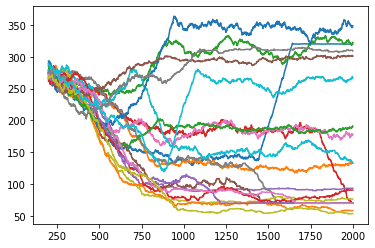

In [272]:
n_firm = 0
for sample in range(20):
    plt.plot(range(2000),prices[:,n_firm,sample])
plt.show()

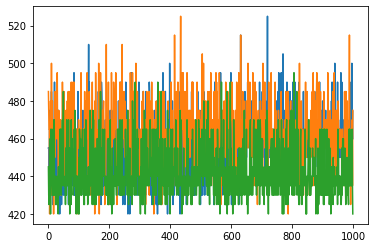

In [178]:
price_df = pd.DataFrame(prices)
for price in price_df.columns   :
    n = len(price_df)
    plt.plot(range(n),price_df.loc[:,price])


## Functions

#### Reinforcement

![reinforcement](reinforcement.png)

In [130]:
@njit
def propensions_reinforcement_part1(bid,propension,profit,lambda_,delta,gamma):
    """Reinforcing bid : 
    Args :
        bid (int): bid value
        propension (float) : propension of bid
        profit (float) : profit at period p
        lambda_ (int) : bid picked at period p
        gamma (float) : forget rate 
        delta (flaot) : propension increaser
    Returns:
        new_propension (float): reinforced propension
        """
    # First step : comparison between previously picked bid 
    # and current bid
    new_propension = 0
    if bid==lambda_:
        new_propension = (1-gamma)*propension+profit
    elif bid == lambda_-1 or bid == lambda_ +1:
        new_propension = (1-gamma)*propension+profit*(1-delta)
    else:
        new_propension = (1-gamma)*propension
    return new_propension